### Задача:
Будем решать частичную задачу на собственные значения на многообразии $S^{n-1}$
методами Римановой оптимизации.

### Описание алгоритма:
Пусть у нас фиксирована матрица $A \in \mathbb{R}^{n\times n}$. Тогда для
фиксированной матрицы $A$ определим отношение Реллея $f\colon S^{n - 1} \to \mathbb{R}$
по правилу

\begin{align*}
x \mapsto (x, Ax)
\end{align*}


Решать задачу будем при помощи Риманова градиентного спуска: пусть имеется некоторое
начальное приближение $x_0 \in S^{n-1}$. Тогда на $k+1$-ой итерации алгоритма

1. Считаем $\nabla f(x_k)$ методами autodiff;
2. Считаем $\nabla_R f(x_k)$ (Риманов градиент) по правилу $\nabla_R f(x_k) = P_{T_{x_k}S^{n-1}}(\nabla f(x_k))$;
3. Вычисляем длину шага $\alpha_k$ при помощи Armijo backtracking;
4. $x_{k+1} =\mathcal{R}_{x_k}(-\alpha_k \nabla_R f(x_k)) \to \min_{x \in S^{n-1}} f(x)$;

Здесь $\mathcal{R}_{x}\colon T_xS^{n-1} \to S^{n-1}$ — стандартная ретракция
\begin{align*}
v \mapsto \frac{x + v}{\|x + v\|_2}
\end{align*}.

Считаем, что алгоритм сошёлся, когда для заданного $\varepsilon > 0$ выполнено

\begin{align*}
\|Ax_k - f(x_k)x_k\|_2 < \varepsilon
\end{align*}.

In [25]:
import jax
import jax.numpy as jnp
from numpy import random
import matplotlib.pyplot as plt
import scipy.sparse
%matplotlib inline

In [2]:
make_rayleigh = lambda A: lambda x: jnp.inner(x, A @ x)

def retraction(x, v):
    res = x + v
    return res / jnp.linalg.norm(res)

make_residual = lambda A: lambda x, rayleigh_x: jnp.linalg.norm(A @ x - rayleigh_x * x)
orthoprojector = lambda x: jnp.eye(len(x)) - jnp.outer(x, x)

#### Armijo backtracking
Идея: имеется некоторое начальное приближение $\alpha_0$, на каждой итерации алгоритм
выполняет умножение $\alpha_{k+1} = \beta\alpha_k$, $\beta \in (0, 1)$, до тех
пор, пока не выполнено уcловие Армихо-Голдштейна:

\begin{align*}
f(x) - f(\mathcal{R}_{x}(-\alpha_k \nabla_R f(x))) \geq m\alpha_k\|\nabla_R f(x)\|^2
\end{align*}

где $m \in (0, 1)$. Литература сообщает, что обычно $m = 10^{-4}, \beta \in \{0.5, 0.8\}$.

In [3]:
def armijo_backtracking(init, grad, mul, beta, func, x):
    alpha = init
    while func(x) - func(retraction(x, -alpha * grad)) < \
        mul * alpha * jnp.linalg.norm(grad) ** 2:
        alpha *= beta
    return alpha

In [92]:
def predefine_GD(A):
    rayleigh = make_rayleigh(A)
    residual = make_residual(A)

    def riemanGD(init, tol, max_iter = None, debug = False):
        x = init
        residuals = [residual(x, rayleigh(x))]
        iters = 0
        if debug == True:
            print("№\tresidual")
        while residual(x, rayleigh(x)) > tol:
            regular_grad = jax.grad(rayleigh)
            P = orthoprojector(x)
            rieman_grad = P @ regular_grad(x)
            alpha = armijo_backtracking(10, rieman_grad, 1E-4, 0.8, rayleigh, x)
            x = retraction(x, -alpha*rieman_grad)
            iters += 1
            residuals.append(residual(x, rayleigh(x)))
            if debug == True:
                print("{}\t{}".format(iters, residual(x, rayleigh(x))))
            if max_iter is not None and iters >= max_iter:
                break

        return x, residuals

    return riemanGD

#### Иргушечный тест и промежуточные выводы

In [65]:
print("Toy test: A = diag(24, 12, 0, -7)")
init_x = random.randn(4)
init_x = jnp.array(init_x / jnp.linalg.norm(init_x))
tolerance = 1E-8
A = jnp.diagflat(jnp.array([24, 12, 0, -7]))
riemanGD = predefine_GD(A)
vec = riemanGD(init_x, tolerance, 50, True)[0]
print("found eigenvalue {}".format(make_rayleigh(A)(vec)))

Toy test: A = diag(24, 12, 0, -7)
№	residual
1	12.497602462768555
2	5.624430179595947
3	4.6260666847229
4	3.979995012283325
5	3.5015034675598145
6	2.6293909549713135
7	2.3973453044891357
8	1.8457330465316772
9	1.706756591796875
10	1.3283768892288208
11	1.038434386253357
12	0.813911497592926
13	0.638949453830719
14	0.5980278849601746
15	0.4700210988521576
16	0.3696073293685913
17	0.29073938727378845
18	0.27247506380081177
19	0.25536876916885376
20	0.23934508860111237
21	0.22433410584926605
22	0.17652328312397003
23	0.16546978056430817
24	0.13021574914455414
25	0.1024768278002739
26	0.08064894378185272
27	0.07560639083385468
28	0.05950305983424187
29	0.046829961240291595
30	0.03685619682073593
31	0.034552495926618576
32	0.027193667367100716
33	0.025493988767266273
34	0.023900553584098816
35	0.018810369074344635
36	0.014804271049797535
37	0.011651371605694294
38	0.010923157446086407
39	0.010240455158054829
40	0.008059524931013584
41	0.006343072280287743
42	0.004992176778614521
43	0.002144

Итого на диагональной матрице $4\times4$ метод нашёл правильное младшее
собственное значение и сошёлся за 50 итераций, что, как мне кажется, довольно грустно.

Кроме того видно, что на последних нескольких итерациях метод уже ничего не делал, но при
этом ошибка довольно большая. Вероятно это связано с использованием типа float32.

P.S. Ясно, что неплохое начальное приближение можно получить из степенного метода,
что нам абсолютно не интересно, т.к. не пригодится при обобщении метода на
многомерный случай.

#### Больше тестов

Создадим большие плотные симметричные матрицы с не очень большими
собственными значениями, и будем запускать метод на них с потолком в 50 итераций.
Везде будем использовать факт, что если $A$ - симметричная матрица, то
$C^TAC$ - тоже симметричная, при условии, что $\det C \neq 0$.

Сначала запустим метод с потенциально плохими матрицами $C$:

Actual -199, found -34359736.0, err 34359536.0
Actual -200, found -34146464.0, err 34146264.0
Actual -200, found -34578136.0, err 34577936.0
Actual -200, found -35182704.0, err 35182504.0
Actual -198, found -32054508.0, err 32054310.0
Actual -200, found -33017618.0, err 33017418.0
Actual -200, found -34957672.0, err 34957472.0
Actual -200, found -34115312.0, err 34115112.0
Actual -200, found -32206176.0, err 32205976.0
Actual -200, found -33761812.0, err 33761612.0


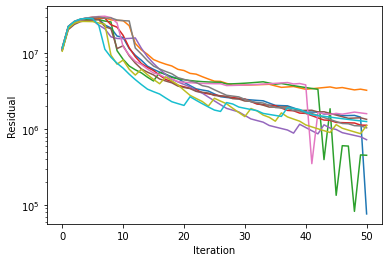

In [66]:
n = 10
dim = 1000
tolerance = 4E-3
graphs = []
for i in range(n):
    A = jnp.diagflat(jnp.array(random.randint(-200, 200, dim)))
    answ = jnp.amin(A)
    C = jnp.array(10 * random.randn(dim, dim))
    A = C.T @ A @ C
    riemanGD = predefine_GD(A)
    init_x = random.randn(dim)
    init_x = jnp.array(init_x / jnp.linalg.norm(init_x))
    vec, rs = riemanGD(init_x, tolerance, 50)
    graphs.append(plt.plot(rs))
    eival = make_rayleigh(A)(vec)
    print("Actual {}, found {}, err {}".format(answ, eival, jnp.abs(answ - eival)))

plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.semilogy()
plt.show(graphs)

А теперь запретим матрицам $C$ не быть ортогональными:

Actual -200, found -198.96253967285156, err 1.0374603271484375
Actual -200, found -199.6404571533203, err 0.3595428466796875
Actual -200, found -199.69378662109375, err 0.30621337890625
Actual -200, found -199.5835418701172, err 0.4164581298828125
Actual -200, found -199.3016357421875, err 0.6983642578125
Actual -200, found -199.292724609375, err 0.707275390625
Actual -200, found -199.19821166992188, err 0.801788330078125
Actual -200, found -199.88504028320312, err 0.114959716796875
Actual -200, found -199.67955017089844, err 0.3204498291015625
Actual -200, found -199.2705841064453, err 0.7294158935546875


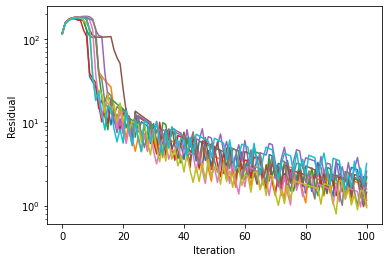

In [67]:
n = 10
dim = 1000
tolerance = 4E-3
graphs = []
for i in range(n):
    A = jnp.diagflat(jnp.array(random.randint(-200, 200, dim)))
    answ = jnp.amin(A)
    C = jnp.array(10 * random.randn(dim, dim))
    C = jnp.linalg.qr(C)[0]
    A = C.T @ A @ C
    riemanGD = predefine_GD(A)
    init_x = random.randn(dim)
    init_x = jnp.array(init_x / jnp.linalg.norm(init_x))
    vec, rs = riemanGD(init_x, tolerance, 100)
    graphs.append(plt.plot(rs))
    eival = make_rayleigh(A)(vec)
    print("Actual {}, found {}, err {}".format(answ, eival, jnp.abs(answ - eival)))

plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.semilogy()
plt.show(graphs)

##### Вывод
Для плохих матриц сходимость приняла ислам, а для хороших
вполне пристойно за 100 итераций сходится к правильному собственному значению.
Примечательно так же то, что первые 10 итераций ошибка растёт, потом резко снижается,
и далее ведёт себя, как при обычном градиентном спуске. Чем обусловлено такое поведение,
я сказать затрудняюсь...

Предлагаю взять какую-нибудь плохую матрицу и посмотреть, за сколько итераций метод
для неё сойдётся к чему-то адекватному.

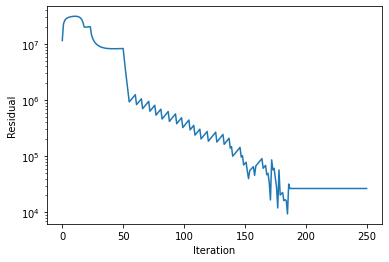

In [88]:
dim = 1000
tolerance = 4E-3
A = jnp.diagflat(jnp.array(random.randint(-200, 200, dim)))
answ = jnp.amin(A)
C = jnp.array(10 * random.randn(dim, dim))
A = C.T @ A @ C
riemanGD = predefine_GD(A)
init_x = random.randn(dim)
init_x = jnp.array(init_x / jnp.linalg.norm(init_x))
vec, rs = riemanGD(init_x, tolerance, 250)
plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.semilogy()
plt.show(plt.plot(rs))

In [89]:
make_rayleigh(A)(vec)


DeviceArray(-34650670., dtype=float32)

Сошлось, блин.

### Ищем несколько собственных значений

Глобально идея та же самая, только теперь вместо одного вектора $x_k$ у нас
будет матрица с нормированными столбцами $X_k$, которую мы будем воспринимать
как коллекцию векторов, лежащих на сфере. Эту матрицу мы будем ортогонализовывать
на каждой итерации, чтобы разные столбцы сошлись к собственным векторам, лежащим
в разных собственных подпространствах.

Немного переделаем алгоритм: пусть у нас всё ещё есть фиксированная матрица
$A \in \mathbb{R}^{n\times n}$. Тогда новое "отношение Реллея" будет иметь вид
$f\colon S^{n-1} \to \mathbb{R}^m$ по правилу $X \mapsto diag(X^TAX)$, где $m$ —
сколько собственных значений мы хотим найти. Соответветственно, если
$X_0 \in (S^{n-1})^m$ — начальное приближение, то на $k+1$-ой итерации
алгоритма

1. Считаем $\nabla f(X_k)$ (матрица, где каждый столбец это $\nabla f(X_k^{(i)})$) методами autodiff;
2. Считаем $\nabla_R f(X_k)$ (аналогично) по правилу $\nabla_R f(X_k^{(i)}) = P_{T_{X_k^{(i)}}S^{n-1}}(\nabla f(X_k^{(i)}))$;
3. Вычисляем длину шага $\alpha_k^i$ при помощи Armijo backtracking для каждого столбца;
4. $X_{k+1} =\mathcal{R}_{X_k}(-\nabla_R f(X_k)\alpha_k) \to \min_{X \in (S^{n-1})^m} f(X)$;

Здесь $\alpha_k$ — диагональная матрица с длинами шагов, а
$\mathcal{R}_{X_k} \colon \mathbb{R}^{n\times m} \to (S^{n-1})^m$ — новая
ретракция по правилу $M \mapsto QR(X_k + M)$.

А теперь со всем этим дерьмом мы попытаемся взлететь....

P.S. Хорошая попытка, но такое отношение Реллея не получится продифференцировать.
Придётся вернуть старое отношение и применять его к каждому столбцу.


In [20]:
make_rayleigh = lambda A: lambda x: jnp.inner(x, A @ x)

def new_retraction(X, M):
    res = X + M
    return jnp.linalg.qr(res)[0]

make_residual = lambda A: lambda X: jnp.linalg.norm(A @ X - X @ (X.T @ (A @ X)))

In [21]:
def predefine_GD_multiple_eigenvals(A):
    rayleigh = make_rayleigh(A)
    residual = make_residual(A)

    def riemanGD_multiple_eigenvals(init, tol, max_iter = None, debug = False):
        X = init
        residuals = [residual(X)]
        iters = 0
        if debug == True:
            print("№\tresidual")
        while residual(X) > tol:
            regular_grad = jax.grad(rayleigh)
            P = jnp.array([orthoprojector(X[:, i]) for i in range(X.shape[1])])
            rieman_grad = jnp.array([P[i] @ regular_grad(X[:, i]) for i in range(X.shape[1])]).T
            # rieman_grad = jnp.array([P[i] @ regular_grad(X[:, i]) for i in range(X.shape[1])])
            alpha = jnp.array([armijo_backtracking(10, rieman_grad[:, i], 1E-4, 0.8, rayleigh, X[:, i]) for i in range(X.shape[1])])
            X = new_retraction(X, -rieman_grad @ jnp.diagflat(alpha))
            iters += 1
            residuals.append(residual(X))
            if debug == True:
                print("{}\t{}".format(iters, residual(X)))
            if max_iter is not None and iters >= max_iter:
                break

        return X, residuals

    return riemanGD_multiple_eigenvals

In [205]:
print("Toy test: A = diag(24, 12, 0, -7)")
init_X = random.randn(4, 3)
init_X = jnp.linalg.qr(init_X)[0]
tolerance = 7E-3
A = jnp.diagflat(jnp.array([24, 12, 0, -7]))
riemanGD_multiple_eigenvals = predefine_GD_multiple_eigenvals(A)
vec = riemanGD_multiple_eigenvals(init_X, tolerance, 108, True)[0]

Toy test: A = diag(24, 12, 0, -7)
№	residual
1	10.02748966217041
2	3.4817159175872803
3	0.4458751380443573
4	0.15850038826465607
5	0.08101204037666321
6	0.08528738468885422
7	0.15879331529140472
8	0.3456290662288666
9	0.7878841161727905
10	1.786104679107666
11	3.713104248046875
12	5.803286552429199
13	6.208337306976318
14	6.432803153991699
15	6.211984157562256
16	6.214503288269043
17	6.120805263519287
18	6.1126275062561035
19	6.067671298980713
20	6.06010103225708
21	6.040382385253906
22	6.032987117767334
23	6.02579402923584
24	6.0196404457092285
25	6.01495361328125
26	6.011295318603516
27	6.008194923400879
28	6.006038665771484
29	6.00356388092041
30	6.001966953277588
31	5.999105930328369
32	5.997056007385254
33	5.992273330688477
34	5.987917423248291
35	5.978078365325928
36	5.9671173095703125
37	5.945052146911621
38	5.916943550109863
39	5.865636825561523
40	5.794182777404785
41	5.672691822052002
42	5.492953300476074
43	5.202481269836426
44	4.75941801071167
45	4.07941198348999
46	3.09845

In [206]:
print(make_rayleigh(A)(vec[:, 0]))
print(make_rayleigh(A)(vec[:, 1]))
print(make_rayleigh(A)(vec[:, 2]))



-7.0
3.2512362e-16
12.0


Жесть, оно сработало. Запускать его на больших тестах нет никакого желания, но оно
работает, а это уже больше, чем я ожидал....